# Analyze network consequences of protein abundance changes - GPX4
Currently set up for a single model
## Setup
### Import packages

In [1]:
from pathlib import Path
from operator import attrgetter
from warnings import warn
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from cobra.flux_analysis import find_blocked_reactions
from cobra.flux_analysis.variability import flux_variability_analysis
from rbc_gem_utils import (
    get_dirpath,
    COBRA_CONFIGURATION,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PREFIX_SUFFIX_VALUES,
    ProteinDilution,
    ComplexDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username
Set parameter LicenseID to value 2664189

Package Information
-------------------
rbc-gem-utils 0.0.2

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
gurobipy                             11.0.1
matplotlib                            3.8.2
matplotlib-venn                       1.1.1
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues due to protein constraint bounds
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "DeepRedOmics"

### Set computation options

In [4]:
protein_of_interest = "GPX4"


protein_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.dilution"]
protein_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.metabolite"]
relax_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.relaxation"]

budget_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.dilution"]
budget_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.metabolite"]

### Set figure options

In [5]:
save_figures = True
transparent = False
imagetype = "svg"

## Load RBC-GEM model

In [6]:
valid_organisms = {"Human", "Mouse"}
if organism not in valid_organisms:
    raise ValueError(f"Organism must be one of the following: {valid_organisms}")

# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id

results_dirpath = get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name

fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "sample_pcmodels"
abundance_change_results_path = results_dirpath / "abundance_changes"

# Ensure directories exist
abundance_change_results_path.mkdir(exist_ok=True, parents=True)

model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=sample_pcmodels_dirpath / f"{model_id}_PC_{dataset_name}.xml")
pcmodel

Name,RBC_GEM_PC_DeepRedOmics
Memory address,14e2e8610
Number of metabolites,10411
Number of reactions,19620
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


### Set protein of interest

In [7]:
protein_gene = pcmodel.genes.get_by_id(protein_of_interest)
protein_met = pcmodel.metabolites.get_by_id(f"{protein_met_prefix}{protein_of_interest}_pc")
protein_rxn = pcmodel.reactions.get_by_id(f"{protein_rxn_prefix}{protein_met.id}")

# Store IDs for later use
protein_mid = protein_met.id
protein_rid = protein_rxn.id
protein_relax_id = f"{relax_rxn_prefix}{protein_mid}"

biochemical_reactions = []
for reaction in sorted(protein_gene.reactions, key=attrgetter("id")):
    if reaction in model.reactions:
        print(model.reactions.get_by_id(reaction.id))
        biochemical_reactions += [reaction.id]
protein_gene

GTHP: 2.0 gthrd_c + h2o2_c --> gthox_c + 2.0 h2o_c
HPDHA10GTHR: 2.0 gthrd_c + hpdha10_c --> gthox_c + h2o_c + hdha10_c
HPDHA11GTHR: 2.0 gthrd_c + hpdha11_c --> gthox_c + h2o_c + hdha11_c
HPDHA13GTHR: 2.0 gthrd_c + hpdha13_c --> gthox_c + h2o_c + hdha13_c
HPDHA14GTHR: 2.0 gthrd_c + hpdha14_c --> gthox_c + h2o_c + hdha14_c
HPDHA16GTHR: 2.0 gthrd_c + hpdha16_c --> gthox_c + h2o_c + hdha16_c
HPDHA17GTHR: 2.0 gthrd_c + hpdha17_c --> gthox_c + h2o_c + hdha17_c
HPDHA20GTHR: 2.0 gthrd_c + hpdha20_c --> gthox_c + h2o_c + hdha20_c
HPDHA4GTHR: 2.0 gthrd_c + hpdha4_c --> gthox_c + h2o_c + hdha4_c
HPDHA7GTHR: 2.0 gthrd_c + hpdha7_c --> gthox_c + h2o_c + hdha7_c
HPDHA8GTHR: 2.0 gthrd_c + hpdha8_c --> gthox_c + h2o_c + hdha8_c
HPEPE11GTHR: 2.0 gthrd_c + hpepe11_c --> gthox_c + h2o_c + hepe11_c
HPEPE12GTHR: 2.0 gthrd_c + hpepe12_c --> gthox_c + h2o_c + hepe12_c
HPEPE15GTHR: 2.0 gthrd_c + hpepe15_c --> gthox_c + h2o_c + hepe15_c
HPEPE18GTHR: 2.0 gthrd_c + hpepe18_c --> gthox_c + h2o_c + hepe18_c
HPEPE5

Gene identifier,GPX4
Name,GPX4
Memory address,0x1506ee690
Functional,True
In 148 reaction(s),"HPEPE11GTHR, ENZFM_enzyme_HPETE12GTHR_fwd_cplx_MONOMER_GPX4_pc, HPETE5GTHR, ENZDL_enzyme_HPDHA14GTHR_rev_pc, ENZDL_enzyme_HPEPE5GTHR_total_pc, ENZDL_enzyme_HPDHA16GTHR_fwd_pc,..."


### Get original values from model

In [8]:
budget_met_relax = pcmodel.metabolites.get_by_id(f"{budget_met_prefix}relaxation")
budget_rxn_relax = pcmodel.reactions.get_by_id(f"{budget_rxn_prefix}{budget_met_relax}")

orig_relax_budget = budget_rxn_relax.bounds
orig_protein_bounds = protein_rxn.bounds

### Minimize relaxation budget

In [9]:
print("Old relaxation bounds: ({:.6f}, {:.6f})".format(*orig_relax_budget))
# update_slack_value(pcmodel, 0.0012, verbose=True)

relaxdl_reaction = pcmodel.reactions.get_by_id(f"{relax_rxn_prefix}{protein_met_prefix}{protein_of_interest}_pc")
relaxdl_reaction.bounds = (0, 0)

budget_rxn_relax.upper_bound = budget_rxn_relax.lower_bound
print("New relaxation bounds: ({:.6f}, {:.6f})".format(*budget_rxn_relax.bounds))

Old relaxation bounds: (0.001928, 5.041332)
New relaxation bounds: (0.001928, 0.001928)


### Ensure model can optimize all reactions catalyzed by protein of interest

In [10]:
objective_reactions = ["NaKt"] + biochemical_reactions
pcmodel.objective = sum([rxn.flux_expression for rxn in pcmodel.reactions.get_by_any(objective_reactions)])
sol = pcmodel.optimize(raise_error=True)

# Display solution for objective fluxes
objective_sol = sol.fluxes.loc[objective_reactions]
print(f"Optimization objective: {sol.objective_value:.6f}\n{objective_sol}")
# Protein utilized
protein_sol = sol.fluxes.loc[[protein_rid, protein_relax_id]]
print(f"\nProtein utilized: {protein_sol.sum():.6f}\n{protein_sol}")
# Required relaxation budget
relax_sol = sol.fluxes.loc[pcmodel.reactions.query(lambda x: x.id.startswith("RELAX_") or x.id.endswith(budget_met_relax.id)).list_attr("id")]
relax_sol = relax_sol[relax_sol != 0]
relax_budget_used = relax_sol.loc[budget_rxn_relax.id]
print(f"\nTotal relaxation budget utilized: {relax_budget_used:.6f} ({relax_budget_used / budget_rxn_relax.upper_bound:.4%})\n{relax_sol}")

Optimization objective: 1.146159
NaKt           0.024619
GTHP           0.851134
HPDHA10GTHR    0.000000
HPDHA11GTHR    0.000000
HPDHA13GTHR    0.000000
HPDHA14GTHR    0.000000
HPDHA16GTHR    0.000000
HPDHA17GTHR    0.000000
HPDHA20GTHR    0.000000
HPDHA4GTHR     0.000000
HPDHA7GTHR     0.000000
HPDHA8GTHR     0.000000
HPEPE11GTHR    0.000000
HPEPE12GTHR    0.000000
HPEPE15GTHR    0.000000
HPEPE18GTHR    0.000000
HPEPE5GTHR     0.000000
HPEPE8GTHR     0.135203
HPEPE9GTHR     0.000000
HPETE11GTHR    0.000000
HPETE12GTHR    0.000000
HPETE15GTHR    0.000000
HPETE5GTHR     0.000000
HPETE8GTHR     0.000000
HPETE9GTHR     0.135203
HPODE13GTHR    0.000000
HPODE9GTHR     0.000000
PGG1GTHR       0.000000
PGG2GTHR       0.000000
PGG3GTHR       0.000000
Name: fluxes, dtype: float64

Protein utilized: 0.774605
PROTDL_protein_GPX4_pc    0.774605
RELAX_protein_GPX4_pc     0.000000
Name: fluxes, dtype: float64

Total relaxation budget utilized: 0.001928 (100.0000%)
BDL_budget_relaxation      0.001928

## Optimal fluxes as a function of reduction in protein abundance

In [11]:
percent_interval = (0, -100)
proteome_rxns_of_interest =  [
    protein_rid,
    protein_relax_id,
]
biochemical_rxns_of_interest = [
    "G6PDH2",
    "PGL", 
    "GND", 
    "RPI", 
    "RPE", 
    "TKT1",
    "TALA", 
    "TKT2", 
]
objective_reactions = ["NaKt"] + biochemical_reactions


solutions = []
with pcmodel:
    protein_reaction = pcmodel.reactions.get_by_id(protein_rid)
    pcmodel.objective = sum([rxn.flux_expression for rxn in pcmodel.reactions.get_by_any(biochemical_reactions)])
    
    
    for percent in np.linspace(*percent_interval, 1 + (percent_interval[0] - percent_interval[1])):
        protein_reaction.bounds = (
            orig_protein_bounds[0] * (1 + percent/100),
            orig_protein_bounds[1] * (1 + percent/100),
        )
        sol = pcmodel.optimize()
        sols_of_interest = sol.fluxes.loc[
            biochemical_rxns_of_interest
            + [x for x in objective_reactions if x not in biochemical_rxns_of_interest]
            + [x for x in proteome_rxns_of_interest if x not in objective_reactions]
        ]
        sols_of_interest.name = percent
        solutions.append(sols_of_interest)

df_solutions = pd.concat(solutions, axis=1)
df_solutions

,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,...,-91.0,-92.0,-93.0,-94.0,-95.0,-96.0,-97.0,-98.0,-99.0,-100.0
NaKt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GTHP,0.851134,0.844386,0.837637,0.830889,0.824141,0.817393,0.810644,0.803896,0.797148,0.790399,...,0.237038,0.230290,0.223541,0.216793,0.210045,0.203296,0.196548,0.189800,0.183051,0.176303
HPDHA10GTHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HPDHA11GTHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HPDHA13GTHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HPDHA14GTHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HPDHA16GTHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HPDHA17GTHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HPDHA20GTHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HPDHA4GTHR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Plot results for flux as a function of protein abundance

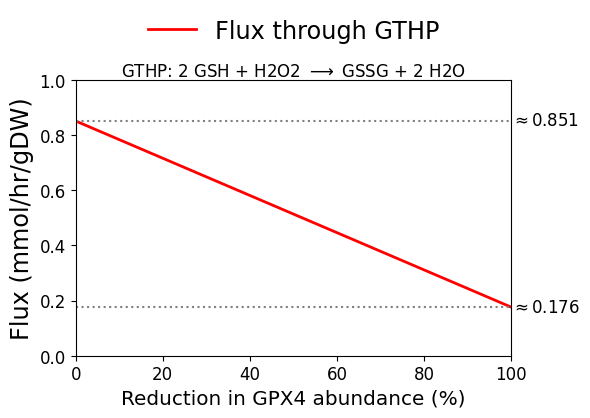

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

xmin, xmax = (0, 100)
# Plot GTHP
GTHP_flux = df_solutions.loc[["GTHP"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
GTHP_flux.index *= -1
GTHP_flux.plot(
    ax=ax, 
    color="red", 
    linewidth=2, 
    label=f"Flux through GTHP",
)
ax.hlines(GTHP_flux.min(), xmin=xmin, xmax=xmax, color="grey", ls=":")
ax.hlines(GTHP_flux.max(), xmin=xmin, xmax=xmax, color="grey", ls=":")
ax.annotate(
    f"$\\approx{GTHP_flux.max():.3f}$", 
    xy=(100, GTHP_flux.max()*.98), 
    xycoords="data",
    fontsize="large"
)
ax.annotate(
    f"$\\approx{GTHP_flux.min():.3f}$", 
    xy=(100, GTHP_flux.min()*.9), 
    xycoords="data",
    fontsize="large"
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1)
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")
ax.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="x-large")
ax.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax.annotate(
    "GTHP: 2 GSH + H2O2 $\\longrightarrow$ GSSG + 2 H2O", 
    xy=(0.5, 1.03),
    ha="center",
    va="center",
    xycoords="axes fraction",
    fontsize="large"
)
ax.legend(bbox_to_anchor=(0.5, 1.3), loc="upper center", frameon=False, fontsize="xx-large")


ftype = "svg"
fig.tight_layout()
fig.savefig(abundance_change_results_path / f"Reduction_{protein_of_interest}_PanelA.{ftype}", transparent=True, format=ftype)

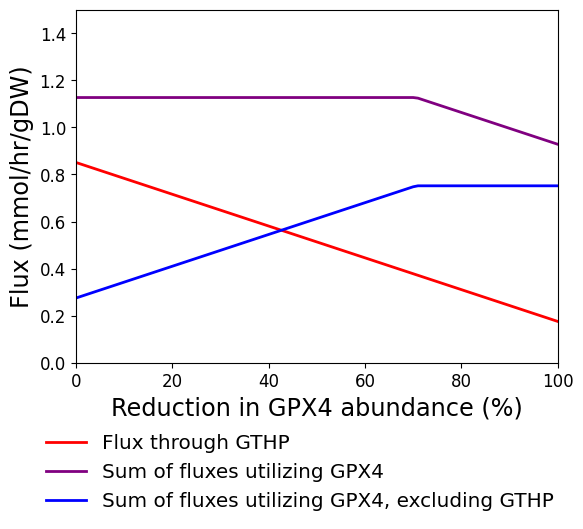

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))

# Plot GTHP
GTHP_flux = df_solutions.loc[["GTHP"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
GTHP_flux.index *= -1
GTHP_flux.plot(
    ax=ax, 
    color="red", 
    linewidth=2, 
    label=f"Flux through GTHP",
)


# Plot sum of all fluxces
sum_of_fluxes = df_solutions.loc[biochemical_reactions].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
sum_of_fluxes.index *= -1
sum_of_fluxes.plot(
    ax=ax, 
    color="purple",
    linewidth=2, 
    label=f"Sum of fluxes utilizing {protein_of_interest}",
)

# Plot sum of all fluxces excluding GTHP
sum_of_fluxes_wo_GTHP = df_solutions.loc[[x for x in biochemical_reactions if x != "GTHP"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
sum_of_fluxes_wo_GTHP.index *= -1
sum_of_fluxes_wo_GTHP.plot(
    ax=ax, 
    color="blue",
    linewidth=2, 
    label=f"Sum of fluxes utilizing {protein_of_interest}, excluding GTHP",
)



ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1.5)
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")

ax.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="xx-large")
ax.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax.legend(bbox_to_anchor=(-0.1, -.15), loc="upper left", frameon=False, fontsize="x-large")

ftype = "svg"
fig.tight_layout()
fig.savefig(abundance_change_results_path / f"Reduction_{protein_of_interest}_PanelB.{ftype}", transparent=True, format=ftype)

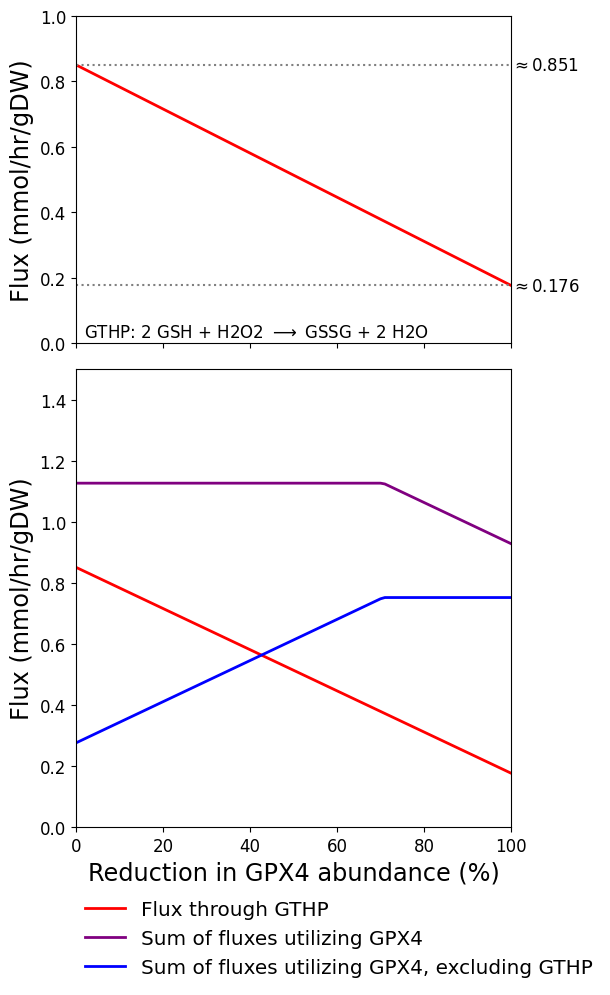

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=True, sharey=False, height_ratios=[1, 1.4])
(ax1, ax2) = axes.flatten()

xmin, xmax = (0, 100)
# Plot GTHP
GTHP_flux = df_solutions.loc[["GTHP"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
GTHP_flux.index *= -1
GTHP_flux.plot(
    ax=ax1, 
    color="red", 
    linewidth=2, 
    label=f"Flux through GTHP",
)
ax1.hlines(GTHP_flux.min(), xmin=xmin, xmax=xmax, color="grey", ls=":")
ax1.hlines(GTHP_flux.max(), xmin=xmin, xmax=xmax, color="grey", ls=":")
ax1.annotate(
    f"$\\approx{GTHP_flux.max():.3f}$", 
    xy=(100, GTHP_flux.max()*.98), 
    xycoords="data",
    fontsize="large"
)
ax1.annotate(
    f"$\\approx{GTHP_flux.min():.3f}$", 
    xy=(100, GTHP_flux.min()*.9), 
    xycoords="data",
    fontsize="large"
)

ax1.annotate(
    "GTHP: 2 GSH + H2O2 $\\longrightarrow$ GSSG + 2 H2O", 
    xy=(0.02, 0.02), 
    xycoords="axes fraction",
    fontsize="large",
)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(0, 1)
ax1.xaxis.set_tick_params(labelsize="large")
ax1.yaxis.set_tick_params(labelsize="large")
# ax1.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="x-large")
ax1.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")




# Plot GTHP
GTHP_flux = df_solutions.loc[["GTHP"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
GTHP_flux.index *= -1
GTHP_flux.plot(
    ax=ax2, 
    color="red", 
    linewidth=2, 
    label=f"Flux through GTHP",
)


# Plot sum of all fluxces
sum_of_fluxes = df_solutions.loc[biochemical_reactions].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
sum_of_fluxes.index *= -1
sum_of_fluxes.plot(
    ax=ax2, 
    color="purple",
    linewidth=2, 
    label=f"Sum of fluxes utilizing {protein_of_interest}",
)

# Plot sum of all fluxces excluding GTHP
sum_of_fluxes_wo_GTHP = df_solutions.loc[[x for x in biochemical_reactions if x != "GTHP"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
sum_of_fluxes_wo_GTHP.index *= -1
sum_of_fluxes_wo_GTHP.plot(
    ax=ax2, 
    color="blue",
    linewidth=2, 
    label=f"Sum of fluxes utilizing {protein_of_interest}, excluding GTHP",
)



ax2.set_xlim(xmin, xmax)
ax2.set_ylim(0, 1.5)
ax2.xaxis.set_tick_params(labelsize="large")
ax2.yaxis.set_tick_params(labelsize="large")

ax2.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="xx-large")
ax2.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax2.legend(bbox_to_anchor=(-0.02, -.12), loc="upper left", frameon=False, fontsize="x-large")

ftype = "svg"
fig.tight_layout()
fig.savefig(abundance_change_results_path / f"Reduction_{protein_of_interest}.{ftype}", transparent=True, format=ftype)